In [11]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [6]:
base_path = '../../datasets/'

dataset_path = os.path.join(base_path, '4-dataset')
train_path = os.path.join(base_path, 'training')
valid_path = os.path.join(base_path, 'validation')

In [3]:
class_names = []
split_ratio = 0.6

# Loop melalui setiap folder (menggunakan NPM sebagai nama folder)
for npm_folder in os.listdir(dataset_path):
  folder_path = os.path.join(dataset_path, npm_folder)

  # Cek apakah folder tersebut adalah direktori
  if os.path.isdir(folder_path):
    # List semua file dalam folder tersebut
    files = os.listdir(folder_path)

    # Jika ada lebih dari 2 file, kita akan melakukan split
    if len(files) >= 2:
      class_names.append(npm_folder)
      # Buat folder training dan validation jika belum ada
      os.makedirs(os.path.join(train_path, npm_folder), exist_ok=True)
      os.makedirs(os.path.join(valid_path, npm_folder), exist_ok=True)

      # Hitung jumlah file yang akan dipindahkan ke training
      num_files_to_move = int(len(files) * split_ratio)

      # Acak urutan file
      random.shuffle(files)

      # Pindahkan file ke folder training dan validation
      for i, file in enumerate(files):
        if i < num_files_to_move:
          # Pindahkan ke folder training
          shutil.copy(os.path.join(folder_path, file), os.path.join(train_path, npm_folder, file))
        else:
          # Pindahkan ke folder validation
          shutil.copy(os.path.join(folder_path, file), os.path.join(valid_path, npm_folder, file))
    else:
        print(f"Folder {npm_folder} kurang dari 2 file. Skipping...")

print("Data splitting completed.")

Data splitting completed.


In [4]:
num_classes = len(class_names)

NameError: name 'class_names' is not defined

In [15]:
train_data_gen = ImageDataGenerator(rescale=1/255)
validate_data_gen = ImageDataGenerator(rescale=1/255)

In [16]:
train_gen = train_data_gen.flow_from_directory(train_path, (128,128))
validate_gen = validate_data_gen.flow_from_directory(valid_path, (128,128))

Found 44 images belonging to 4 classes.


Found 30 images belonging to 4 classes.


In [17]:
def residual_block(x, filters, stride=1, use_projection=False):
    identity = x

    # First convolution layer in the block
    x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer in the block
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer in the block
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Projection shortcut for identity
    if use_projection:
        identity = Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding='valid')(identity)
        identity = BatchNormalization()(identity)

    # Adding the identity (skip connection) to the output
    x = Add()([x, identity])
    x = ReLU()(x)

    return x

In [18]:
def build_resnet101(input_shape=(128, 128, 3), num_classes=train_gen.num_classes):
    input_tensor = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(22):
        x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = Dense(train_gen.num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet101')

    return model

In [19]:
# Build ResNet-101 model
resnet101 = build_resnet101()

# Display model summary
resnet101.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 64, 64, 64)           0         ['batch_normalization[

In [20]:
resnet101.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
saveBestModel = tf.keras.callbacks.ModelCheckpoint('../../datasets/restnet101_best_model.h5',
                                                   monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [12]:
history = resnet101.fit(train_gen, steps_per_epoch=len(train_gen),
          epochs=400,
          validation_data=validate_gen,
          callbacks=[saveBestModel]
          )

Epoch 1/400
2/2 [==============================] - ETA: 0s - loss: 1.8988 - accuracy: 0.3409 
Epoch 1: val_accuracy improved from -inf to 0.26667, saving model to ../../datasets\restnet101_best_model.h5


c:\Users\ramad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 24s 4s/step - loss: 1.8988 - accuracy: 0.3409 - val_loss: 1.4143 - val_accuracy: 0.2667
Epoch 2/400
2/2 [==============================] - ETA: 0s - loss: 4.3018 - accuracy: 0.4545
Epoch 2: val_accuracy did not improve from 0.26667
2/2 [==============================] - 3s 1s/step - loss: 4.3018 - accuracy: 0.4545 - val_loss: 1.3953 - val_accuracy: 0.2667
Epoch 3/400
2/2 [==============================] - ETA: 0s - loss: 1.7845 - accuracy: 0.4545
Epoch 3: val_accuracy did not improve from 0.26667
2/2 [==============================] - 3s 3s/step - loss: 1.7845 - accuracy: 0.4545 - val_loss: 1.4623 - val_accuracy: 0.2667
Epoch 4/400
2/2 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.5455
Epoch 4: val_accuracy did not improve from 0.26667
2/2 [==============================] - 4s 3s/step - loss: 1.1269 - accuracy: 0.5455 - val_loss: 1.6270 - val_accuracy: 0.2667
Epoch 5/400
2/2 [==============================] - ETA: 0s - lo

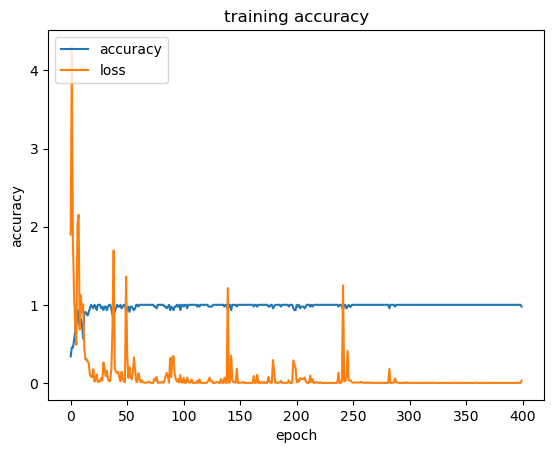

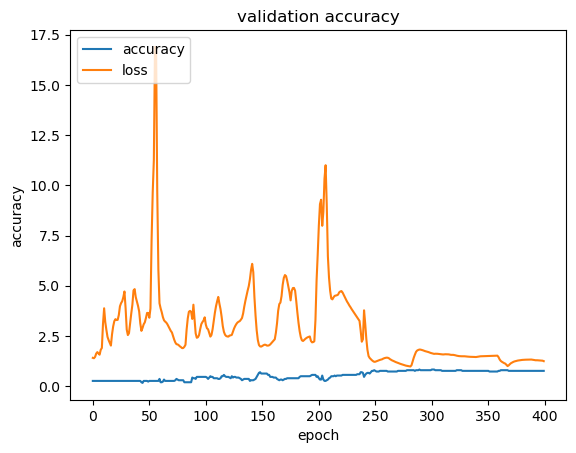

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [20]:
train_gen.class_indices

{'2017051001': 0, '2017051017': 1, '2117051009': 2, '2117051019': 3}

In [27]:
# def pred_img(model, img):
#     X = image.img_to_array(img)
#     X = np.expand_dims(X, axis=0)
#     images = np.vstack([X])
#     val = model.predict(images)
    
#     # Menggunakan argmax untuk mendapatkan indeks kelas dengan probabilitas tertinggi
#     predicted_class_index = np.argmax(val, axis=1)

    

#     # Menentukan kelas berdasarkan indeks
#     if predicted_class_index == 0:
#         return '2017051001'
#     elif predicted_class_index == 1:
#         return '2017051017'
#     elif predicted_class_index == 2:
#         return '2117051009'
#     elif predicted_class_index == 3:
#         return '2117051019'
#     else:
#         return 'Foto Tidak Terdaftar'


In [8]:
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: '2017051001', 1: '2017051017', 2: '2117051009', 3: '2117051019'}

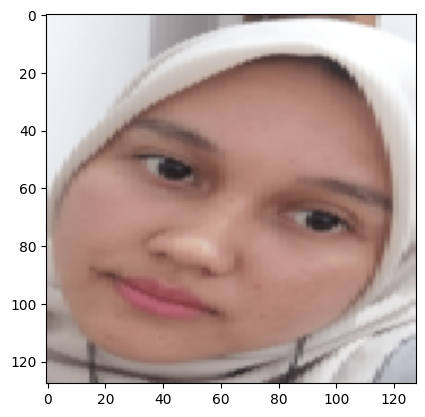

1/1 [==============================] - 0s 99ms/step
Prediksi :  ['2117051009']


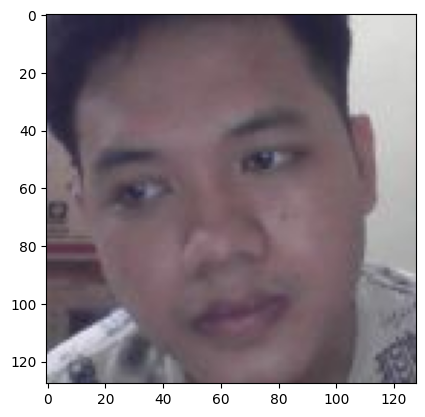

1/1 [==============================] - 0s 96ms/step
Prediksi :  ['2117051009']


In [26]:
test_path = os.path.join(base_path, 'testing')

for image in os.listdir(test_path):
  image_path = os.path.join(test_path, image)
  img = load_img(image_path, target_size=(128,128))
  plt.imshow(img)
  plt.show()

  X = img_to_array(img)
  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  val = resnet101.predict(images)

  predicted_class_index = np.argmax(val, axis=1)

  labels = (train_gen.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  
  predictions = [labels[k] for k in predicted_class_index]
  print('Prediksi : ', predictions)